# Import libraries

In [1]:
!pip install swig
!pip install gym[box2d]
! pip install pyvirtualdisplay

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.5 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 80.6 MB/s eta 0:00:0000:0100:01
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=495182 sha256=4d73acda6c90b23687e31acacd272347e1fe9fc938125b6f31566b09d29f041d
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [2]:
import gym
from pyvirtualdisplay import Display

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import PIL
import copy

import torch
from torch import nn
import torch.nn.functional as F

# Building the environment

## Testing the environment with random actions

In [3]:
# Set up a virtual display to render the Lunar Lander environment.
Display(visible=0, size=(840, 480)).start();

States size:  (8,)
Number of actions:  4


/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


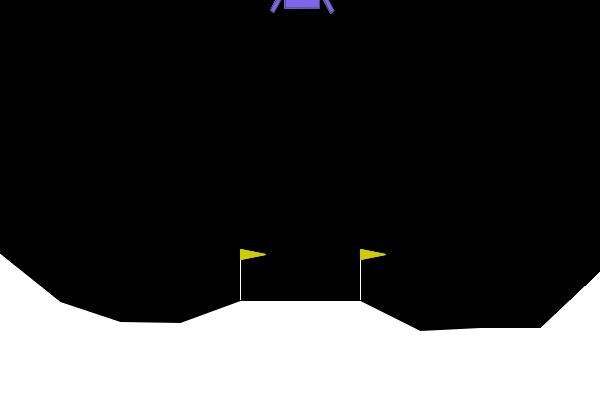

In [72]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')
env.reset()

# Play one complete episode with random actions
while True:
    action = env.action_space.sample()     
    _, _, done, _, _ = env.step(action)
    if done:
        break

print("States size: ",str(env.observation_space.shape))
print("Number of actions: ",str(env.action_space.n))
env.reset()
PIL.Image.fromarray(env.render())

#### Possible actions

In [5]:
actions = {
    0: "do nothing",
    1: "fire left orientation engine",
    2: "fire main engine",
    3: "fire right orientation engine"
    }

# Training

## Dueling architecture + Double DQN algorithm

In [82]:
class D3DQN(nn.Module):
    def __init__(self, input_observations, action_num, lr, chkpt_dir, name):
        super(D3DQN, self).__init__()
        # Save checkpoint path
        self.chkpt_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.chkpt_dir, name)
        # Create the layers               
        self.input = nn.Linear(input_observations, 256)
        
        # V stream
        self.V = nn.Linear(256, 256)
        self.V_output = nn.Linear(256,1)
        
        # A stream
        self.A = nn.Linear(256, 256)
        self.A_output = nn.Linear(256,action_num)
        
        # Optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.loss = torch.nn.HuberLoss()
        
        # Set the GPU or CPU configuration for the network
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, obs_state):
        
        # Input stream
        input = F.relu(self.input(obs_state))       
        
        # V stream
        V = F.relu(self.V(input))
        V = self.V_output(V)
        
        # A stream
        A = F.relu(self.A(input))
        A = self.A_output(A)
        
        return V, A
    
    def save_checkpoint(self):
        print("... saving checkpoint ...")
        torch.save(self.state_dict(), self.checkpoint_file)
        
    def load_checkpoint(self):
        print("... loading checkpoint ...")
        self.load_state_dict(torch.load(self.checkpoint_file))       

# Replay memory

In [9]:
class ReplayBuffer:

    def __init__(self, max_size, pointer):
        # Memory
        self.storage = []
        # Memory size
        self.max_size = max_size
        # Puntero a las diferentes celdas en la memoria
        self.experience_ind = pointer        
        self.full_storage_flag = False

    def add(self, experience):
        ######## Save experience         
        
        if self.experience_ind >= self.max_size:
            self.full_storage_flag = True
            self.experience_ind = 0                
        if self.full_storage_flag:
            self.storage[self.experience_ind] = experience
        else:
            self.storage.append(experience)        
        
        self.experience_ind += 1
        print("EXP ADDED")  

    def sample(self, batch_size):
        # Selecting the experience in memory
        batch = np.random.choice(len(self.storage), batch_size, replace=False)
        minibatch_rewards = []
        minibatch_dones = []        
        minibatch_current_state, minibatch_next_state = np.empty((batch_size, 4)), np.empty((batch_size, 4))

        for i in batch:
            ### Get data
            # Getting current state            
            minibatch_current_state[i, :, :] = self.storage[i][0]                                         
            
            # Getting next state
            minibatch_next_state[i, :, :] = self.storage[i][3]                                         
            
            # Get reward           
            minibatch_rewards.append(self.storage[i][1])                        
            minibatch_dones.append(self.storage[i][4])
            
        return minibatch_current_state, np.array(minibatch_rewards), minibatch_next_state, np.array(minibatch_dones)

# D3DQN algorithm

In [111]:
class DRLAlgorithm:
    def __init__(self):
        
        # Epsilon greedy policy
        self.epsilon = 1.0
        self.epsilon_final = 0.1
        self.epsilon_interval = 1.0 - self.epsilon_final
        self.epsilon_frames = 250_000
        
        # Network
        self.q_net = D3DQN(
            input_observations=8,
            action_num=env.action_space.n,
            lr=0.00025,
            chkpt_dir="model",
            name = "lunar_lander_model"
        )
        self.q_target_net = copy.deepcopy(self.q_net) 
        self.batch_size = 3
        
        # Memory
        self.memory = ReplayBuffer(500_000, 0)
        self.replay_exp_initial_condition = 6
    
    def policy(self, state):
        if np.random.rand() <= self.epsilon:
            action = np.random.randint(0,env.action_space.n)
            return
                
        # Expand dimensions 
        state_tensor = torch.tensor(state).to(q_net.device)
        # Prediction
        V, A = q_net.forward(state_tensor)       
        A_mean = torch.mean(A)       
        action = torch.argmax((V + (A - A_mean))).item()   
        return action
    
    def train(self):
        
        if self.memory.experience_ind <= self.replay_exp_initial_condition:
            return
                
        states_batch, rewards_batch, next_states_batch, dones_batch = self.memory.sample(self.batch_size)
        
        states = torch.tensor(states_batch).to(self.q_net.device)
        next_states = torch.tensor(next_states_batch).to(self.q_net.device)
        rewards = torch.tensor(rewards_batch).to(self.q_net.device)
        dones = torch.tensor(dones_batch).to(self.q_net.device)
        
        self.q_net.optimizer.zero_grad()
        
        indices = np.arange(self.batch_size)
        
        V_s, A_s = self.q_net.forward(states)
        V_s_target, A_s_target = self.q_target_net.forward(next_states)
        
        V_s_eval, A_s_eval = self.q_net.forward(next_states)
        
        
                
        
        
        
        # Select the actions in each next states of the samples
        next_actions = torch.argmax(self.q_net(next_states_batch)).item()
        print(next_actions)
        # Predictions with Q target network
        q_next_preds = self.q_target_net(next_states_batch)        
        
        # Create variables for the next steps
        q_target = np.empty_like(next_actions)               
        
        # Double DQN algorithm
        for idx in range(dones_batch.shape[0]):
            q_target_value = rewards_batch[idx]                     
            if not dones_batch[idx]:                        
                # If not done episode -> evaluate actions predicted
                q_action_evaluated = q_next_preds[idx][next_actions[idx]]
                # Bellman equation variation for Double DQN algorithm                                                
                q_target_value += self.discount*q_action_evaluated                
            # Final Q from Bellman Equation
            q_target[idx] = q_target_value           
        
        print("Training... ")        
        # Training network         
        

        
        # Update epsilon
         # Decay probability of taking random action
        self.epsilon -= self.epsilon_interval / self.epsilon_greedy_frames
        self.epsilon = max(self.epsilon, self.epsilon_final)
        
        self.update_network_counter += 1

        if self.update_network_counter == 8000:
            # Copy weights
            self.q_target_net.load_state_dict(self.q_net.state_dict())
            self.update_network_counter = 1

        print("Training Finished")
        
    def save_model(self):
        self.q_net.save_checkpoint()
    
    def load_model(self):
        self.q_net.load_checkpoint()
        self.q_target_net = copy.deepcopy(self.q_net)
        
        
        

In [114]:
drl = DRLAlgorithm()

## Main

In [115]:
state = env.reset()
state = state[0]
while True:
    action = drl.policy(state)   
    next_state, reward, done, _, _ = env.step(action)    
    experience = [state, reward, action, next_state, done]
    drl.memory.add(experience)
    if done:
        break

EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
EXP ADDED
